# **1. Import**

## *1.1 Import Library*

In [ ]:
from vnstock3 import Vnstock

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pmdarima as pm
import math
import os
import warnings
warnings.filterwarnings('ignore')

from math import sqrt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import het_arch
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from pylab import rcParams



from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose

import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.model_selection import train_test_split

import tensorflow as tf
from sklearn.metrics import r2_score
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False


In [ ]:
# Set stable random
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)

    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed()

Random seed set as 42


In [ ]:
#Funtion to show result
def ml(model, y, y_hat):
    MAE = mean_absolute_error(y, y_hat),
    MAPE = mean_absolute_percentage_error(y, y_hat)
    MSE = mean_squared_error(y, y_hat),
    RMSE = sqrt(mean_squared_error(y, y_hat)),
    R2 = r2_score(y, y_hat)
    return pd.DataFrame(index = [model], data = {'MAE' : MAE,
                                                 'MAPE' : MAPE,
                                                 'MSE' : MSE,
                                                 'RMSE' : RMSE,
                                                 'R2' : R2})

## *1.2 Import data*

In [ ]:
# Import dataset
stock = Vnstock().stock(symbol='VNINDEX', source='VCI')

2024-06-23 19:01:56,995 - vnstock3.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS


In [ ]:
df=stock.quote.history(start='2014-01-01', end='2024-06-21')

In [ ]:
df


,time,open,high,low,close,volume
0,2014-01-02,505.61,506.71,503.04,504.51,57717674
1,2014-01-03,504.41,506.19,503.94,505.37,55600438
2,2014-01-06,505.74,509.10,504.28,509.10,68738380
3,2014-01-07,511.02,513.00,509.87,510.12,74363638
4,2014-01-08,511.03,514.20,509.01,513.90,70296940
...,...,...,...,...,...,...
2602,2024-06-14,1303.37,1305.02,1279.91,1279.91,1110637093
2603,2024-06-17,1281.85,1283.10,1272.54,1274.77,900555134
2604,2024-06-18,1280.29,1286.52,1278.38,1279.50,805289430
2605,2024-06-19,1279.50,1284.14,1270.66,1279.79,1004875853


In [ ]:
df.dtypes

time      datetime64[ns]
open             float64
high             float64
low              float64
close            float64
volume             int64
dtype: object

# **2. EDA**

In [ ]:
data=df.copy()
# Check the first 5 rows of the data set
data.head()

,time,open,high,low,close,volume
0,2014-01-02,505.61,506.71,503.04,504.51,57717674
1,2014-01-03,504.41,506.19,503.94,505.37,55600438
2,2014-01-06,505.74,509.10,504.28,509.10,68738380
3,2014-01-07,511.02,513.00,509.87,510.12,74363638
4,2014-01-08,511.03,514.20,509.01,513.90,70296940


In [ ]:
# Check the data type of data fields
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2607 entries, 0 to 2606
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    2607 non-null   datetime64[ns]
 1   open    2607 non-null   float64       
 2   high    2607 non-null   float64       
 3   low     2607 non-null   float64       
 4   close   2607 non-null   float64       
 5   volume  2607 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 122.3 KB


## *2.1. Cleaning Data*

The data cleaning process includes converting the datatype of the columns to the appropriate types.

In [ ]:
# Change the data fields to the appropriate datatype
data['time'] = pd.to_datetime(data['time'])

In [ ]:
# Convert datatype of Vol. to float by removing "M" and multiplying by 10^6 to get the correct units
data['volume'] = data['volume'].astype(float)

In [ ]:
data.head()

,time,open,high,low,close,volume
0,2014-01-02,505.61,506.71,503.04,504.51,57717674.0
1,2014-01-03,504.41,506.19,503.94,505.37,55600438.0
2,2014-01-06,505.74,509.10,504.28,509.10,68738380.0
3,2014-01-07,511.02,513.00,509.87,510.12,74363638.0
4,2014-01-08,511.03,514.20,509.01,513.90,70296940.0


## *2.2. Exploring Dataset and Explaination*

### 2.2.1. Check the quality of the dataset

In [ ]:
# Check the number of rows and columns of the data set
data.shape

(2607, 6)

In [ ]:
# Check the number of null observations
print(data.isnull().sum())

time      0
open      0
high      0
low       0
close     0
volume    0
dtype: int64


In [ ]:
# Check the number of duplicate observations
print("Number of duplicate observations: " + data.duplicated().sum().astype(str))

Number of duplicate observations: 0


In [ ]:
# Check the number of unique values ​​of each data field
data.nunique()

time      2607
open      2550
high      2560
low       2549
close     2556
volume    2607
dtype: int64

### 2.2.2. Check the fields in the dataset

#### 2.2.2.1. Descriptive Analysis


- Descriptive Statistics data fields in a data set


In [ ]:
data.describe()

,time,open,high,low,close,volume
count,2607,2607.000000,2607.000000,2607.000000,2607.000000,2.607000e+03
mean,2019-04-01 02:19:11.668584704,925.687453,931.461404,919.102267,925.601212,3.579714e+08
min,2014-01-02 00:00:00,504.410000,506.190000,503.040000,504.510000,5.043514e+07
25%,2016-08-22 12:00:00,659.460000,663.775000,655.515000,659.520000,1.278087e+08
50%,2019-04-03 00:00:00,952.970000,959.280000,947.710000,952.770000,1.897561e+08
75%,2021-11-06 12:00:00,1124.710000,1129.995000,1116.295000,1123.780000,5.931845e+08
max,2024-06-20 00:00:00,1534.100000,1536.450000,1524.960000,1528.570000,1.708948e+09
std,NaN,271.201908,272.858148,268.600170,270.879208,3.066643e+08


- Determine outlier (if exists) and perform descriptive statistics on observations with outlier values ​​in data fields

In [ ]:
# Describes observations that are outliers for each field in a data field
def outlier_detection(data, columns):
    result_df = pd.DataFrame(index=data.describe().index)
    for col in columns:
        IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
        lower_bound = data[col].quantile(0.25) - 1.5 * IQR
        upper_bound = data[col].quantile(0.75) + 1.5 * IQR
        # Finding ourliers
        outlier_condition = (data[col] < lower_bound) | (data[col] > upper_bound)
        outliers = data.loc[outlier_condition, col].describe()
        # Create an additional column for each outlier statistic of the data fields
        result_df[f'outlier_{col}'] = outliers
    return result_df

outlier_detection(data, data.columns)

,outlier_time,outlier_open,outlier_high,outlier_low,outlier_close,outlier_volume
count,0,0.0,0.0,0.0,0.0,1.800000e+01
mean,NaT,NaN,NaN,NaN,NaN,1.418818e+09
min,NaT,NaN,NaN,NaN,NaN,1.295576e+09
25%,NaT,NaN,NaN,NaN,NaN,1.344930e+09
50%,NaT,NaN,NaN,NaN,NaN,1.385554e+09
75%,NaT,NaN,NaN,NaN,NaN,1.455758e+09
max,NaT,NaN,NaN,NaN,NaN,1.708948e+09
std,NaN,NaN,NaN,NaN,NaN,1.185669e+08


### 2.2.3. Explore data fields

#### 2.2.3.1. Explore stock price data fields

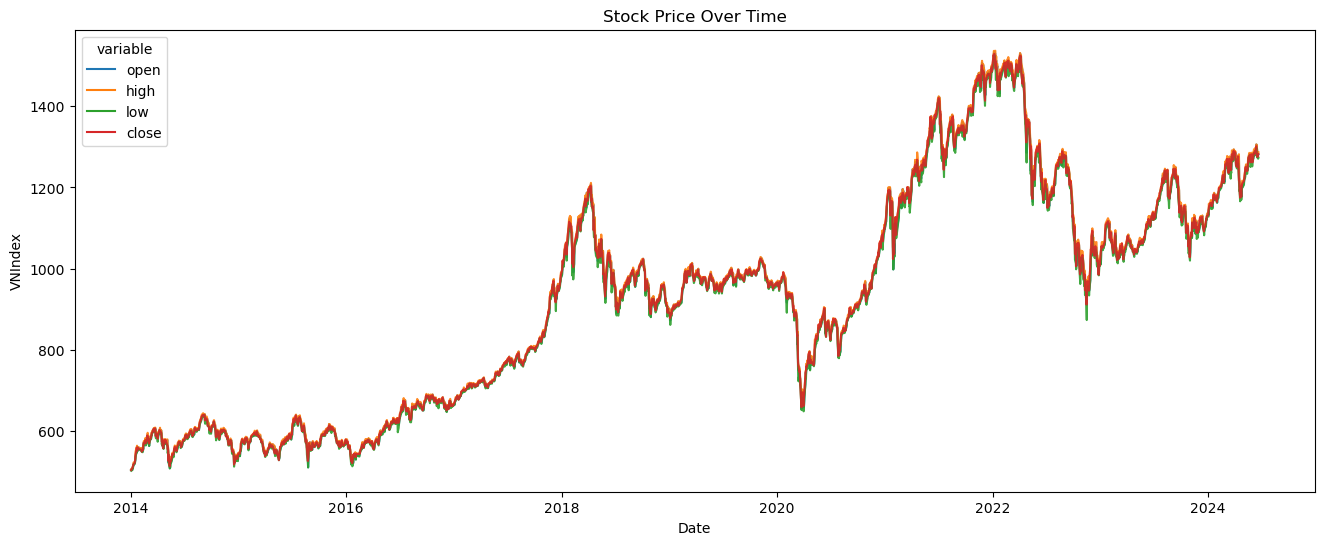

In [ ]:
# A line graph shows the price of a stock over time
dfl = pd.melt(df[['time', 'open', 'high', 'low','close']], ['time'])

plt.figure(figsize=(16, 6))
sns.lineplot(data=dfl,
             x='time',
             y='value',
             hue='variable',  # Add style to differentiate lines
             alpha=0.9)  # Increase alpha to make lines more opaque

plt.title('Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('VNIndex')
plt.show()

<Figure size 1800x500 with 0 Axes>

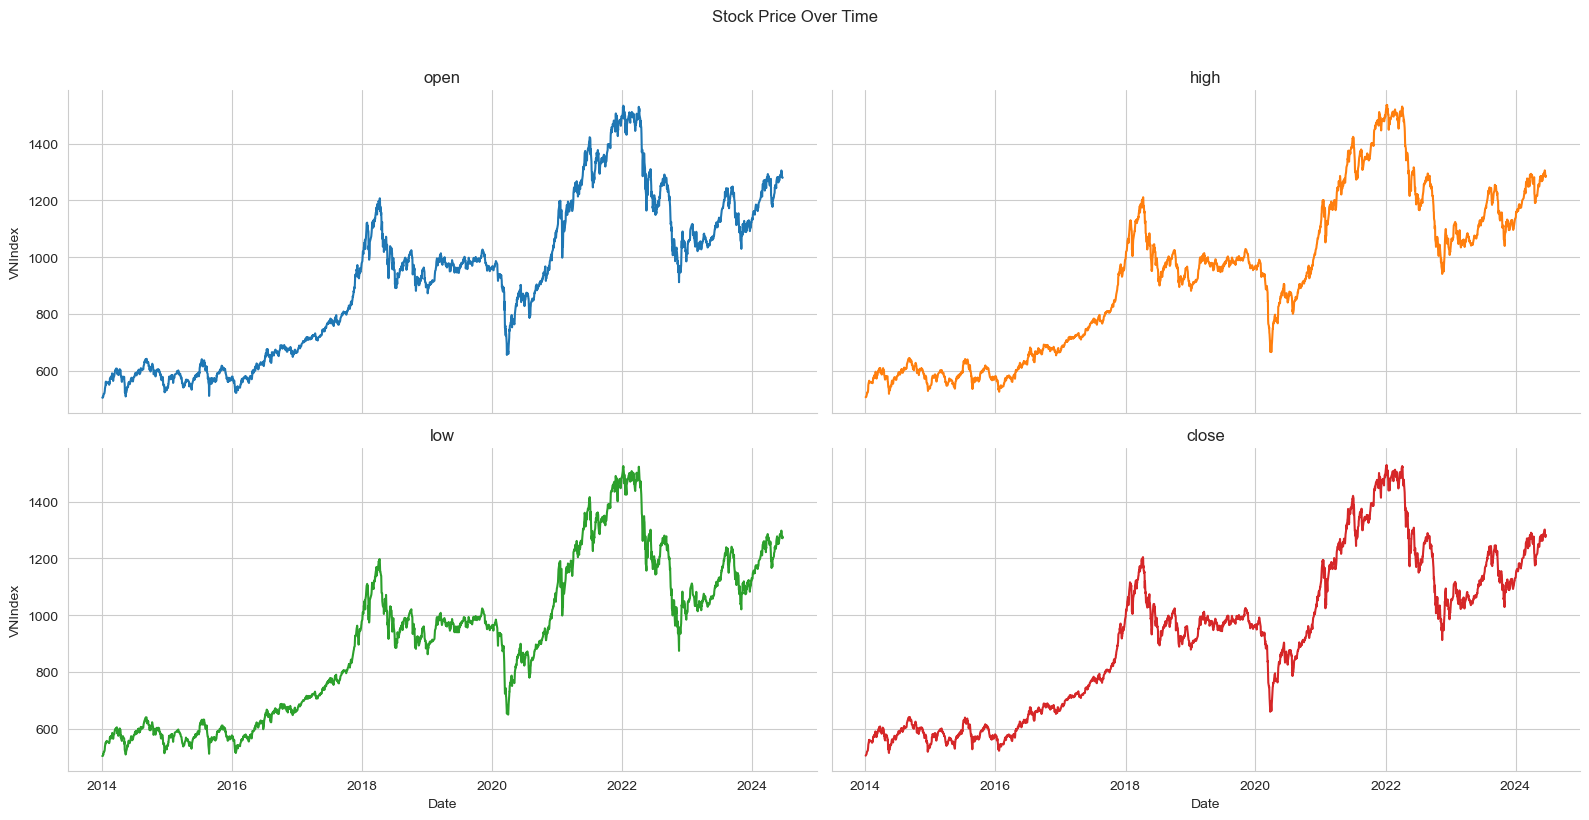

In [ ]:
# Assuming df is already defined and contains the necessary data
dfl = pd.melt(data[['time', 'open', 'high', 'low', 'close']], ['time'])

# Define a color palette for the four different lines
palette = sns.color_palette("tab10", 4)

# Create a FacetGrid with four subplots, one for each variable
g = sns.FacetGrid(dfl, col='variable', col_wrap=2, height=4, aspect=2)

# Map the lineplot to each subplot and set a different color for each variable
variables = dfl['variable'].unique()
for ax, variable, color in zip(g.axes.flatten(), variables, palette):
    sns.lineplot(data=dfl[dfl['variable'] == variable],
                 x='time', y='value', color=color, ax=ax)
    ax.set_title(variable)
    ax.set_xlabel('Date')
    ax.set_ylabel('VNIndex')

# Adjust the overall title and layout
g.fig.suptitle('Stock Price Over Time', y=1.02)
plt.tight_layout()
plt.show()

#### 2.2.3.4: Univariate Analysis

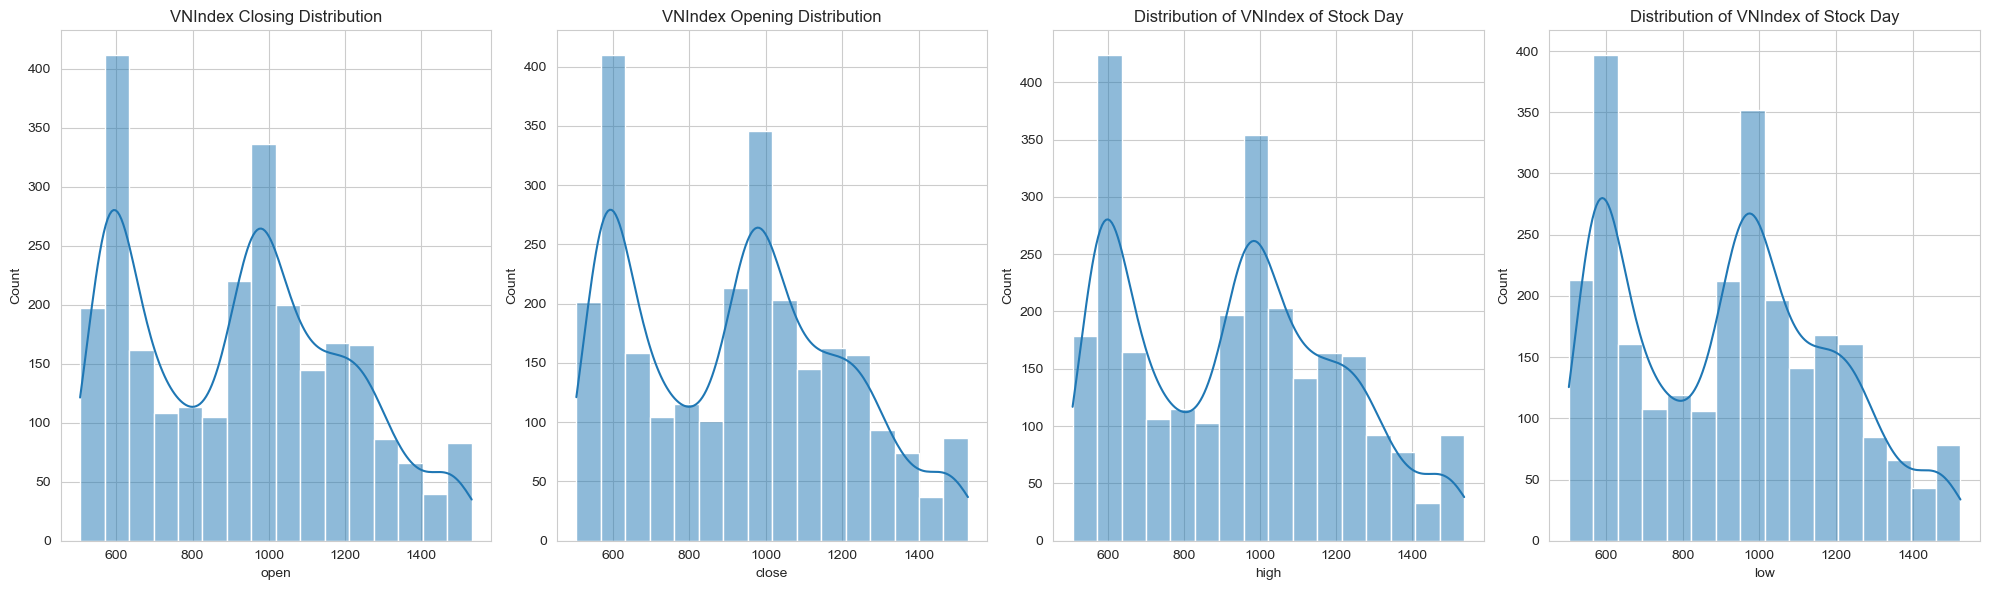

In [ ]:
# Distribution of stock closing prices
fig, axes = plt.subplots(1, 4, figsize = (20,6))

sns.histplot(data['open'], kde=True, ax = axes[0])
axes[0].set_title('VNIndex Closing Distribution')

sns.histplot(data['close'], kde=True, ax = axes[1])
axes[1].set_title('VNIndex Opening Distribution')

sns.histplot(data['high'], kde=True, ax = axes[2])
axes[2].set_title('Distribution of VNIndex of Stock Day')

sns.histplot(data['low'], kde=True, ax = axes[3])
axes[3].set_title('Distribution of VNIndex of Stock Day')

plt.tight_layout()
plt.show()

Next our group will analyze the volume of shares exchanged by day through the line chart below.

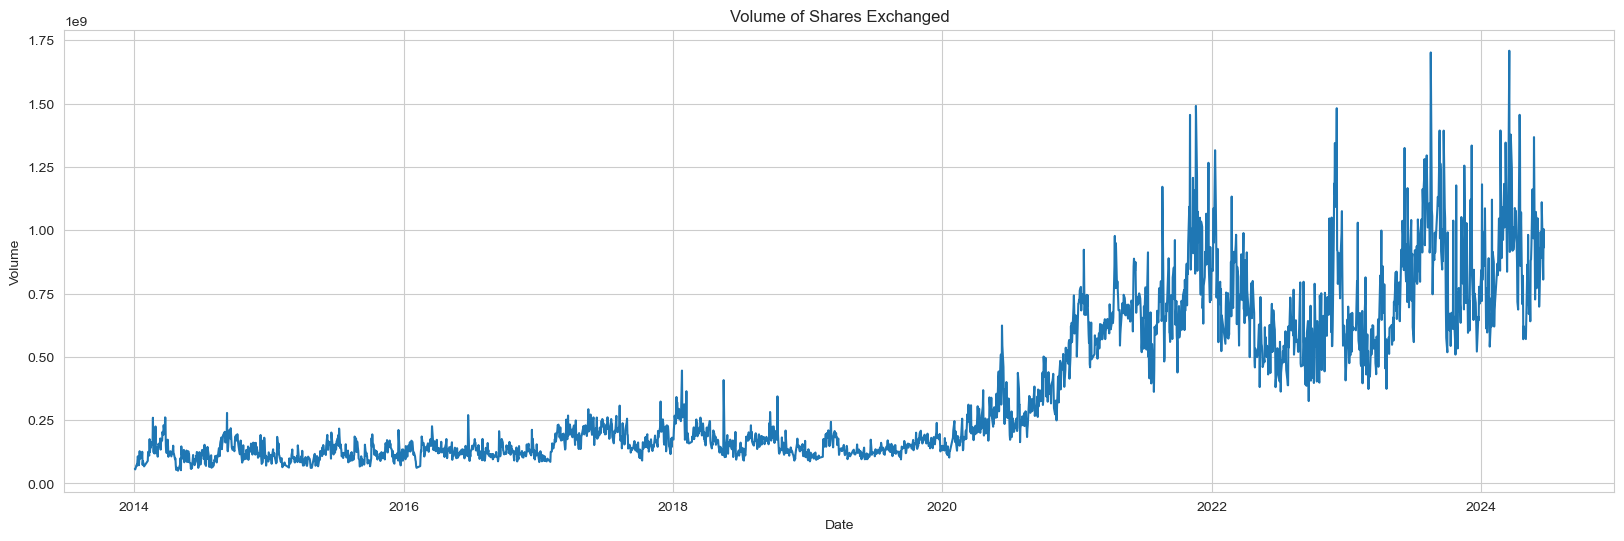

In [ ]:
# Line graph of the volume of shares exchanged by day
plt.figure(figsize=(20, 6))
sns.lineplot(data=data, x='time', y='volume')
plt.title('Volume of Shares Exchanged')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

The line graph above provided shows the trading volume of shares from 2014 to 2024. It displays the fluctuations in trading activity over time, with various peaks indicating periods of high trading volume.

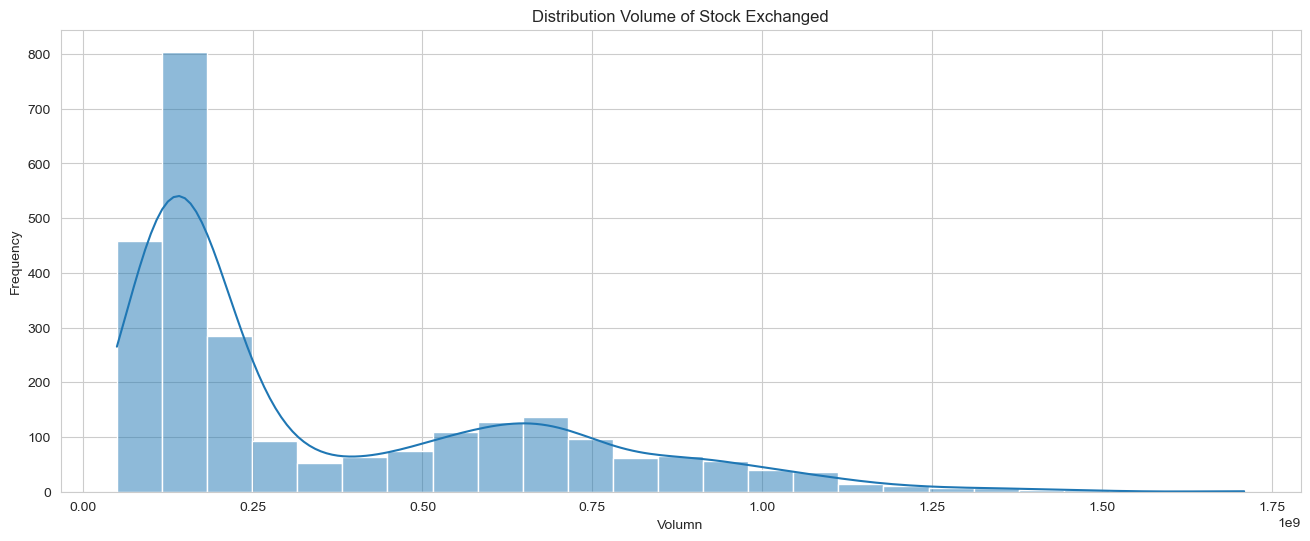

In [ ]:
# Distribution Vol. of HPG stock
plt.figure(figsize=(16, 6))
sns.histplot(data['volume'], kde=True)
plt.title('Distribution Volume of Stock Exchanged')
plt.xlabel('Volumn')
plt.ylabel('Frequency')
plt.show()

#### 2.2.3.4. Bivariate Analysis

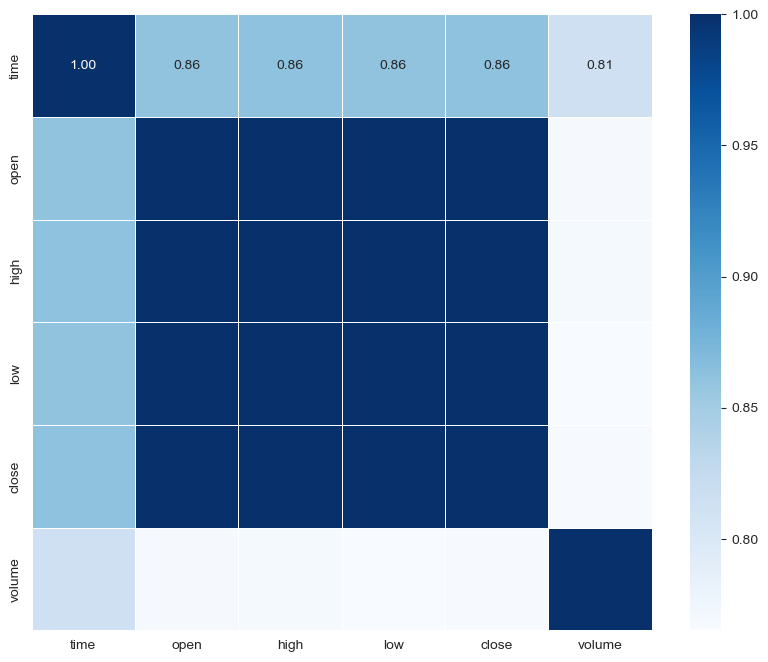

In [ ]:
# Tính toán ma trận tương quan
corr = data.corr()

# Vẽ heatmap
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(corr, annot=True, cmap='Blues', fmt='.2f', linewidths=0.5, linecolor='white')

# Hiển thị heatmap
plt.show()

The cleaned dataset is then exported to a separate file for convenience in future usages of our team in model building.

# 3. Model Building and Evalutions

## 3.1. ARIMA

In [ ]:
df = data.copy()

We set 'time' in our dataframe as our main index so we can reduce the number of relevant preprocessing steps for the dataframe later on.

In [ ]:
# Convert 'Date' to datetime and set as index
df.set_index('time', inplace=True)
df = df.sort_index(ascending=True)

df.head()

,open,high,low,close,volume
time,,,,,
2014-01-02,505.61,506.71,503.04,504.51,57717674.0
2014-01-03,504.41,506.19,503.94,505.37,55600438.0
2014-01-06,505.74,509.10,504.28,509.10,68738380.0
2014-01-07,511.02,513.00,509.87,510.12,74363638.0
2014-01-08,511.03,514.20,509.01,513.90,70296940.0


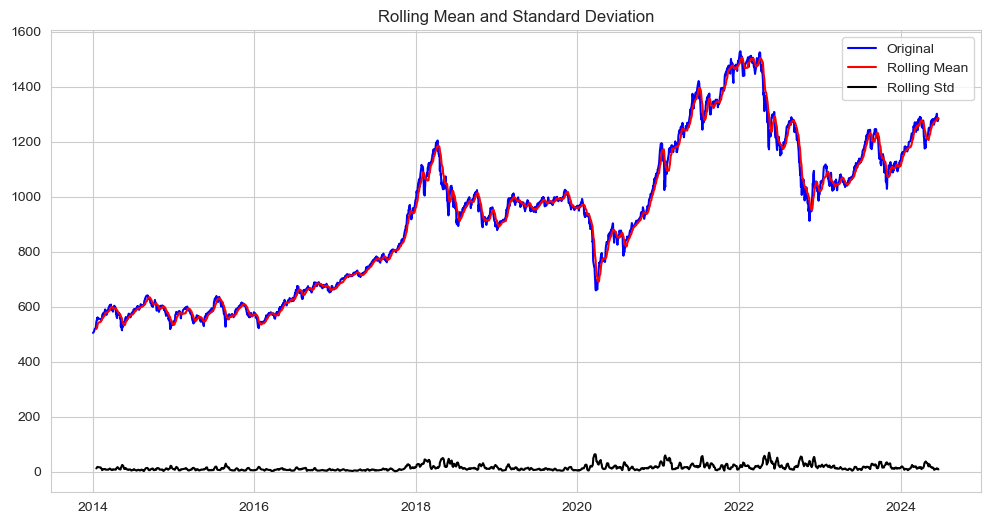

Results of Dickey-Fuller Test:
Test Statistic                   -1.291231
p-value                           0.633174
No. of lags used                  2.000000
Number of observations used    2604.000000
critical value (1%)              -3.432864
critical value (5%)              -2.862651
critical value (10%)             -2.567361
dtype: float64


In [ ]:
# Test for stationarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    # Plot rolling statistics:
    plt.figure(figsize=(12, 6))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show()

    print("Results of Dickey-Fuller Test:")
    adft = adfuller(timeseries, autolag='AIC')

    # Output for dft will give us without defining what the values are.
    # Hence we manually write what values it explains using a for loop
    output = pd.Series(adft[0:4], index=['Test Statistic', 'p-value', 'No. of lags used', 'Number of observations used'])
    for key, value in adft[4].items():
        output['critical value (%s)' % key] = value
    print(output)

# Apply the stationarity test on the 'Price' column
test_stationarity(df['close'])


The time series data visually exhibits a clear upward trend, indicating that the average stock price increases over time. This non-constant mean is a hallmark of non-stationarity. Further visual inspection reveals changing volatility, with price fluctuations becoming more pronounced in later periods. Statistical analysis using the Dickey-Fuller test confirms this non-stationarity, as the test statistic does not fall within the critical region, and the high p-value indicates a failure to reject the null hypothesis of a unit root. Therefore, both visual and statistical evidence strongly suggest that this stock price data is non-stationary and requires appropriate transformations before applying models like ARIMA.

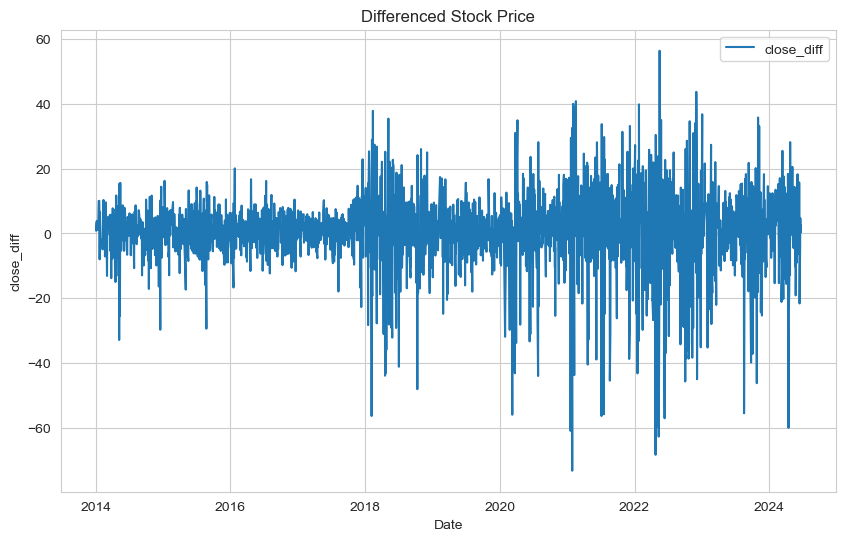

In [ ]:
df['close_diff'] = df['close'].diff().dropna()

# Plot the differenced series
plt.figure(figsize=(10, 6))
plt.plot(df['close_diff'], label='close_diff')
plt.title('Differenced Stock Price')
plt.xlabel('Date')
plt.ylabel('close_diff')
plt.legend()
plt.show()


The price changes oscillate around zero, suggesting a lack of a consistent direction in the stock's movement. While the changes appear largely random, there are periods of increased volatility clustered together, indicating that the stock's price is influenced by underlying market dynamics. A few extreme price changes (outliers) are also noticeable, likely due to significant events impacting the stock. Overall, the plot suggests the differenced stock price might be stationary, making it suitable for modeling with methods that assume stationarity, such as ARIMA.

<Figure size 1000x600 with 0 Axes>

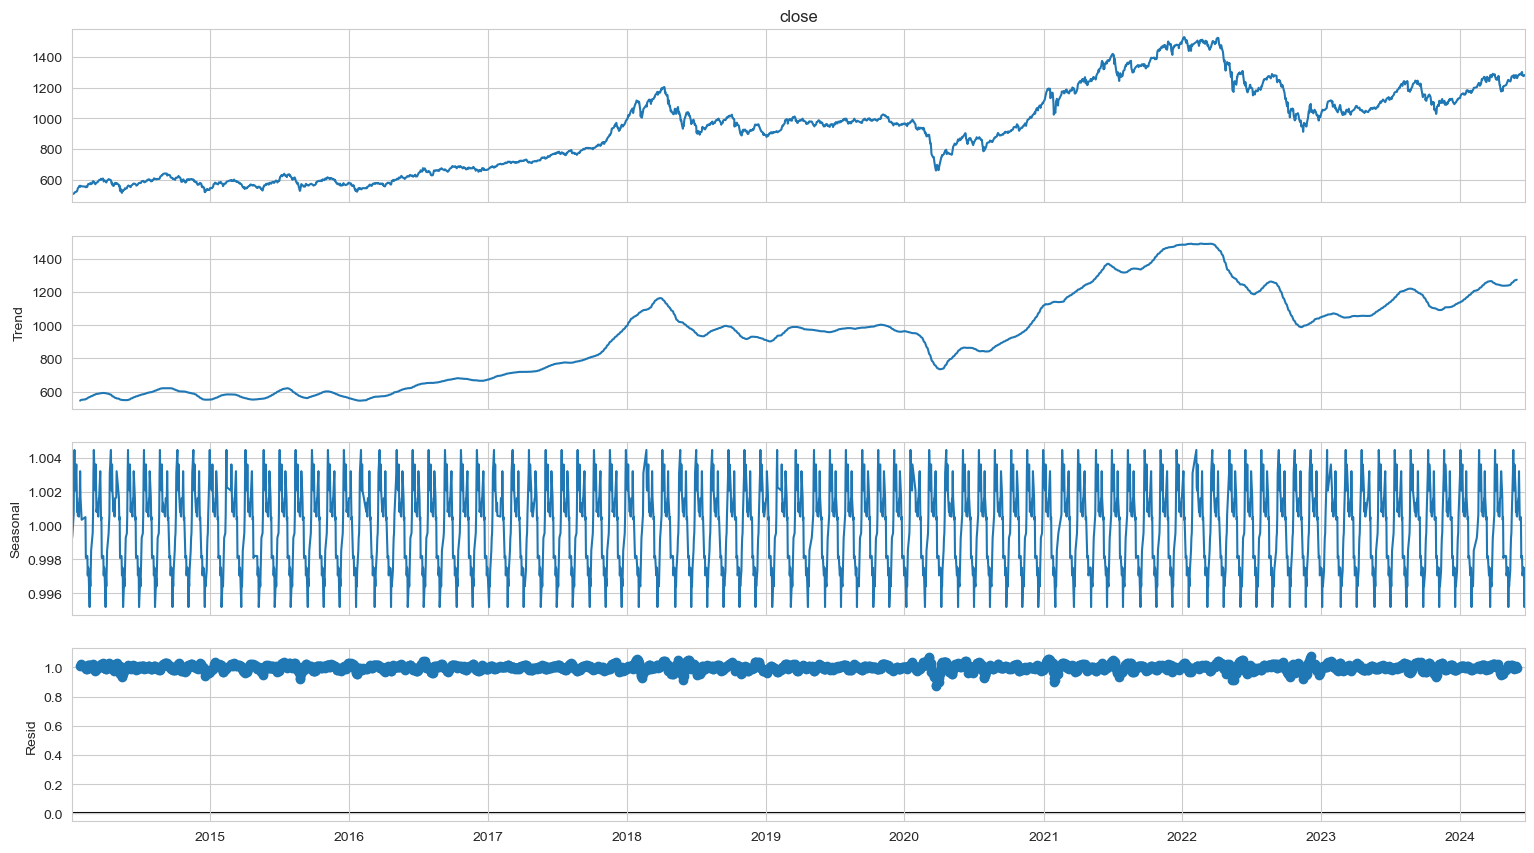

In [ ]:
result = seasonal_decompose(df['close'], model='multiplicative', period=30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)

A consistent seasonal pattern, though smaller in scale compared to the overall trend, indicates regular fluctuations that occur within specific time frames, possibly linked to calendar cycles or market events. The residual component, representing noise and unexplained variations, remains relatively minor, suggesting the trend and seasonal components effectively capture most of the price movements. Overall, the decomposition highlights the strong influence of long-term trends and recurring seasonal patterns on stock prices, with a limited impact from random fluctuations.

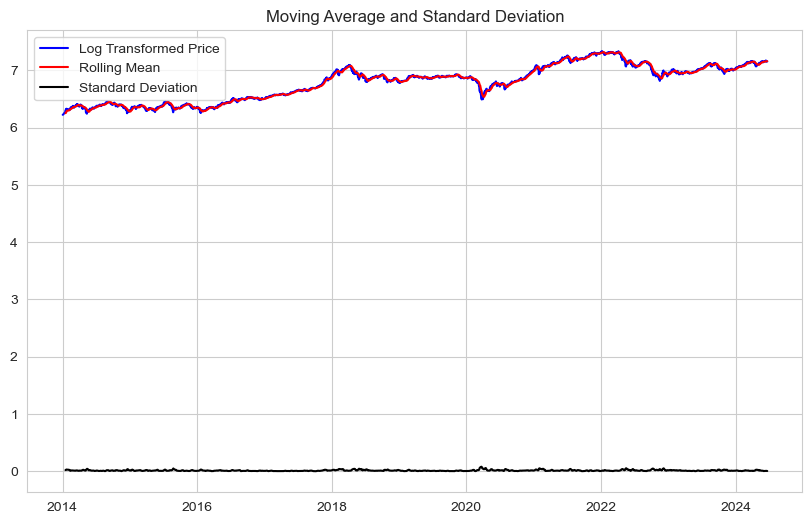

In [ ]:
rcParams['figure.figsize'] = 10, 6

# Log transform the 'Price' column
df_log = np.log(df['close'])

# Calculate rolling mean and standard deviation
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df_log, color='blue', label='Log Transformed Price')
plt.plot(moving_avg, color='red', label='Rolling Mean')
plt.plot(std_dev, color='black', label='Standard Deviation')
plt.legend(loc='best')
plt.title('Moving Average and Standard Deviation')
plt.show()


The plot reveals a clear upward trend in the log-transformed prices, indicating a non-constant mean over time, a hallmark of non-stationarity. The rolling mean closely tracks this trend, further confirming the presence of non-stationarity. Additionally, the rolling standard deviation fluctuates, suggesting that the variance of the data is not constant, further solidifying the non-stationary nature of the log-transformed stock prices.

In [ ]:
# Log transform the 'Price' column
df_log = (df['close'])

# Ensure the 'Date' index is correctly set
df_log.index = df.index

training_data_len = int(np.ceil(len(df_log) - 365))

training_data_len

2242

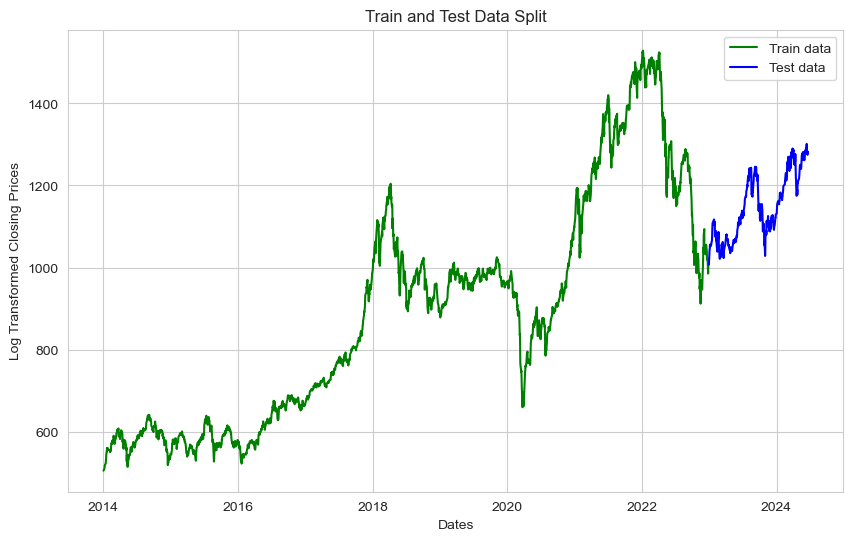

In [ ]:
# Split the data into training and testing sets
train_data = df_log[:training_data_len]
test_data = df_log[training_data_len:]

# Plot the train and test data
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Log Transformed Closing Prices')
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()
plt.title('Train and Test Data Split')
plt.show()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17244.708, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=17242.046, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=17242.314, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=17243.615, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=17242.081, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=17240.758, Time=0.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=17242.721, Time=0.33 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=17242.721, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=17242.190, Time=0.14 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=17244.722, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=17239.450, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=17241.150, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=17240.876, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=17241.410, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0

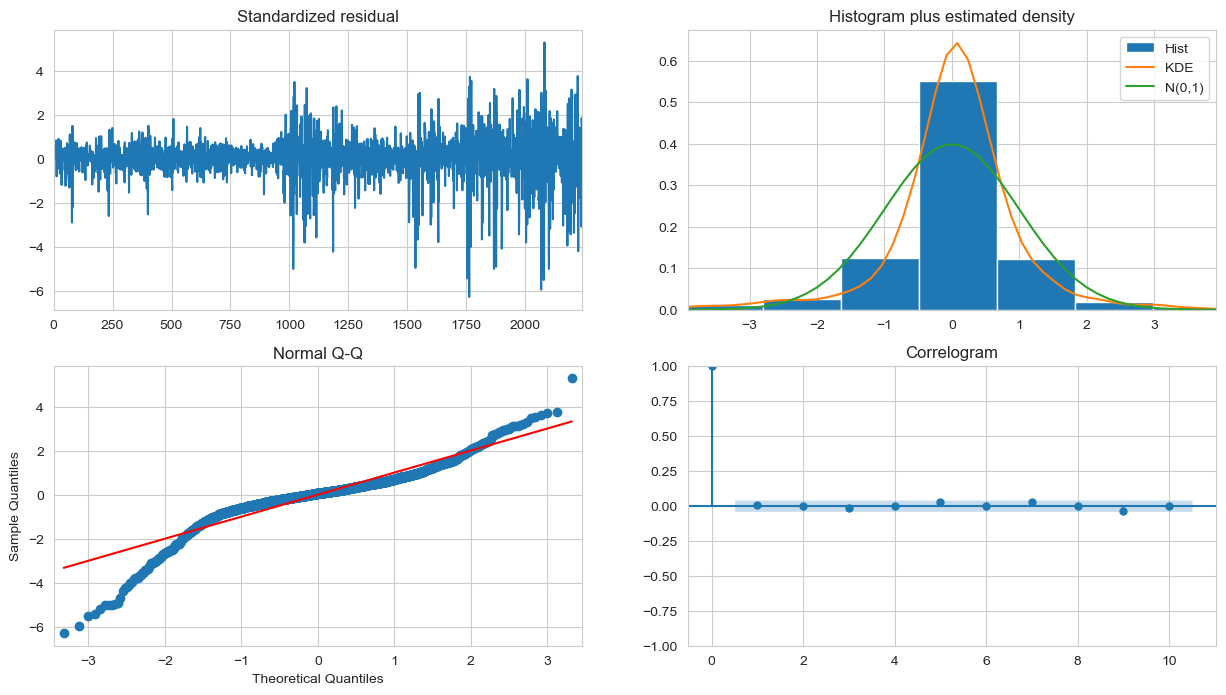

In [ ]:
model_arima = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_arima.summary())
model_arima.plot_diagnostics(figsize=(15,8))
plt.show()

Diagnostic plots reveal that the residuals are roughly normally distributed with no significant autocorrelation, suggesting a reasonable fit of the model to the data.

In [ ]:
# Initialize history with train_data prices
history = train_data.tolist()

# Initialize predictions list
predictions = []

# Walk-forward validation
for t in range(len(test_data)):
    model_arima = ARIMA(history, order=(1, 1, 1))  # ARIMA(1,1,1) model
    model_arima_fit = model_arima.fit()
    output = model_arima_fit.forecast(steps=1)  # Forecast next step only
    predictions.append(output[0])  # Store the prediction

    # Update history with observed Price from test_data
    obs = test_data.iloc[t]
    history.append(obs)

    print(f'predicted={output[0]:.2f}, expected={obs:.2f}')

# Convert predictions to a DataFrame
predictions_df = pd.DataFrame({'Date': test_data.index, 'Predicted_Price': predictions})
predictions_df.set_index('Date', inplace=True)

predicted=1015.85, expected=1009.29
predicted=1009.15, expected=1007.09
predicted=1006.90, expected=1043.90
predicted=1045.29, expected=1046.35
predicted=1047.41, expected=1055.82
predicted=1056.95, expected=1051.44
predicted=1052.03, expected=1054.21
predicted=1054.73, expected=1053.35
predicted=1053.67, expected=1055.76
predicted=1056.08, expected=1056.39
predicted=1056.64, expected=1060.17
predicted=1060.50, expected=1066.68
predicted=1067.17, expected=1088.29
predicted=1089.53, expected=1098.28
predicted=1099.57, expected=1108.08
predicted=1109.39, expected=1117.10
predicted=1118.40, expected=1102.57
predicted=1102.83, expected=1111.18
predicted=1111.74, expected=1075.97
predicted=1074.84, expected=1077.59
predicted=1076.90, expected=1077.15
predicted=1076.66, expected=1089.29
predicted=1089.46, expected=1065.84
predicted=1064.99, expected=1072.22
predicted=1071.90, expected=1064.03
predicted=1063.47, expected=1055.30
predicted=1054.56, expected=1043.70
predicted=1042.70, expected=

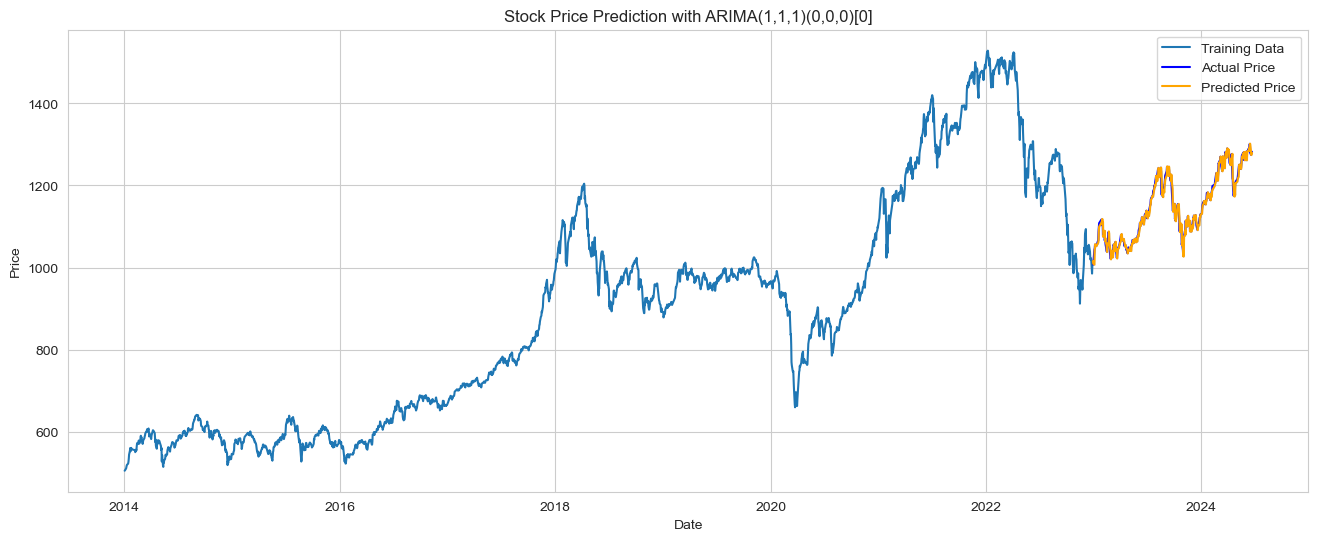

In [ ]:
# Plot the actual vs predicted prices
plt.figure(figsize=(16, 6))
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(test_data.index, test_data, color='blue', label='Actual Price')
plt.plot(predictions_df.index, predictions_df['Predicted_Price'], color='orange', label='Predicted Price')
plt.fill_between(predictions_df.index, test_data, predictions_df['Predicted_Price'], color='k', alpha=0.1)
plt.title('Stock Price Prediction with ARIMA(1,1,1)(0,0,0)[0]')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
arima_result = ml('ARIMA', test_data, predictions)
arima_result

,MAE,MAPE,MSE,RMSE,R2
ARIMA,8.477554,0.7400217597937977,140.008719,11.832528,0.978253


## *3.2. Bi-LSTM Model*

### 3.2.1. Model Preprocessing


The model is preprocessed in these particular steps:
* Create a copy of the original data
* Sort the data by `time` for easy appending and splitting operations later on
* Select only the `time` and `close` columns as these are the columns we are interested in predicting
* Converting the DataFrame into a numpy array to fit within the LSTM model

In [ ]:
np.random.seed(42)
# Creating a copy of the original data
VNI = data.copy()

# Sort the data by Date
VNI = VNI.sort_values(by=['time'])

# Filter out only 'Date' and 'Price' columns
VNI_subset = VNI[['close']]

# Convert the DataFrame to a numpy array
VNI_LSTM = VNI_subset.filter(['close']).values

# Check the data for correct coding
VNI_subset.head()

,close
0,504.51
1,505.37
2,509.10
3,510.12
4,513.90


As we are interested in building a model that can predict stock prices even in the circumstance that extreme external conditions are affecting the dataset, we decide to keep the last 365 days to use as the test dataset.

In [ ]:
# Calculating the number of rows remaining after subtracting the last 365 rows for testing
training_data_len = int(np.ceil(len(VNI_LSTM) - 365))

training_data_len

2242

In [ ]:
# Data scaling with MinMaxScaler()
MMS = MinMaxScaler()
scaled_data = MMS.fit_transform(VNI_LSTM)
scaled_data

array([[0.        ],
       [0.00083979],
       [0.00448216],
       ...,
       [0.75678183],
       [0.75706502],
       [0.75951604]])

In [ ]:
# Create the training dataset previously scaled
train_data = scaled_data[0:int(training_data_len), :]
train_data

array([[0.        ],
       [0.00083979],
       [0.00448216],
       ...,
       [0.46940609],
       [0.48831123],
       [0.49914068]])

The data will then be split into `x_train` and `y_train` with the idea that for any values $i$ in `y_train`, the model will use values from $i - 1$ to $i - size$ to predict that particular value, or a sliding window approach.

The team has tried various `size` values (30, 60, 90, etc) and found that 15 days work best. The reason is because of the large fluctuations of stock price due to events such as the COVID-19 or various wars across the globe. Because of that, looking to far into the past yields little value for the model.

The data is then converted into numpy arrays and reshaped to fit into the Bi-LSTM model.

In [ ]:
# Spliting the train data into x_train and y_train
x_train = []
y_train = []
size = 15

for i in range(size, len(train_data)):
    x_train.append(train_data[i-size:i, 0])
    y_train.append(train_data[i, 0])

# Convert training data into numpy arrays to fit into the model
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(2227, 15, 1)

In [ ]:
# Create the test dataset
test_data = scaled_data[training_data_len - size: , :]

# Split the data sets x_test and y_test with similar ideas to the train dataset
x_test = []
y_test = VNI_LSTM[training_data_len:, :]
for i in range(size, len(test_data)):
    x_test.append(test_data[i-size:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))
x_test.shape

(365, 15, 1)

### 3.2.2. Hyperparameter Tuning

In [ ]:
# Define the hyperparameters to tune
param_dist = {
    'optimizer': ['adam', 'rmsprop'],
    'epochs': [15, 30, 45],
    'batch_size': [16, 32, 64]
}

# Create a function to build the model
def create_model(optimizer):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(Bidirectional(LSTM(64, return_sequences=False)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

# Prepare data
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42)

# Function to get optimizer
def get_optimizer(name):
    if name == 'adam':
        return Adam()
    elif name == 'rmsprop':
        return RMSprop()

# Initialize variables to store the best score and parameters
best_score = float('inf')
best_params = None

# Perform random search
for _ in range(10):  # n_iter = 10
    # Randomly sample hyperparameters
    optimizer_name = np.random.choice(param_dist['optimizer'])
    optimizer = get_optimizer(optimizer_name)
    epochs = np.random.choice(param_dist['epochs'])
    batch_size = np.random.choice(param_dist['batch_size'])

    # Build and train the model
    model = create_model(optimizer)
    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(x_val, y_val))

    # Evaluate the model
    score = model.evaluate(x_val, y_val, verbose=0)

    # Update best score and parameters
    if score < best_score:
        best_score = score
        best_params = {
            'optimizer': optimizer_name,
            'epochs': epochs,
            'batch_size': batch_size
        }

# Print the best score and best parameters
print("Best: %f using %s" % (best_score, best_params))


Best: 0.000260 using {'optimizer': 'adam', 'epochs': 15, 'batch_size': 16}


## 3.2.3. Model Training


In [ ]:
# LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Dense(32))
model.add(Dense(1))



In [ ]:
# Compile the model based on decided optimizer and loss function
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
np.random.seed(42)
model.fit(x_train, y_train, batch_size=16, epochs=45, validation_data=(x_val, y_val), callbacks=early_stopping)

Epoch 1/45
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.7639e-04 - val_loss: 1.3158e-04
Epoch 2/45
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.4425e-04 - val_loss: 1.2612e-04
Epoch 3/45
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.5905e-04 - val_loss: 1.2095e-04
Epoch 4/45
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.7565e-04 - val_loss: 1.3712e-04
Epoch 5/45
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.4503e-04 - val_loss: 1.6933e-04
Epoch 6/45
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.4846e-04 - val_loss: 1.2562e-04
Epoch 7/45
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.6015e-04 - val_loss: 1.2259e-04
Epoch 8/45
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.6821e-04 - val_loss: 1.4472e-04
Epoch 9/45
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.9040e-04 - val_loss: 1.3376e-04
Epoch 10/45
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.9768e-04 - val_loss: 2.2940e-04


### 3.2.4. Model Testing

In [ ]:
# Create the test dataset
test_data = scaled_data[training_data_len - size: , :]

# Split the data sets x_test and y_test with similar ideas to the train dataset
x_test = []
y_test = VNI_LSTM[training_data_len:, :]
for i in range(size, len(test_data)):
    x_test.append(test_data[i-size:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))



In [ ]:
# Predicted values of the model
predictions = model.predict(x_test)
predictions = MMS.inverse_transform(predictions)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


### 3.2.5. Model Evaluation

In [ ]:
y_pred_train = model.predict(x_train)
y_pred = model.predict(x_test)
y_pred = MMS.inverse_transform(y_pred)
result = ml('Bi-LSTM', y_test, y_pred)
result


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


,MAE,MAPE,MSE,RMSE,R2
Bi-LSTM,8.341731,0.728071731769699,137.973583,11.746216,0.978569


In [ ]:
#Model Evaluation Metrics
model_metrics = pd.concat([result, arima_result], axis=0)
model_metrics

,MAE,MAPE,MSE,RMSE,R2
Bi-LSTM,8.341731,0.728071731769699,137.973583,11.746216,0.978569
ARIMA,8.477554,0.7400217597937977,140.008719,11.832528,0.978253


# **4. Results Visualization**

In [ ]:
# Ensure 'time' is a datetime column
VNI['time'] = pd.to_datetime(VNI['time'])

# Create the training data used for plotting
viz_train = VNI[:training_data_len].copy()
viz_train.set_index('time', inplace=True)

# Create the testing and predictions data used for plotting
viz_test = VNI[training_data_len:].copy()
viz_test.set_index('time', inplace=True)
viz_test.insert(1, 'Predictions', predictions, True)

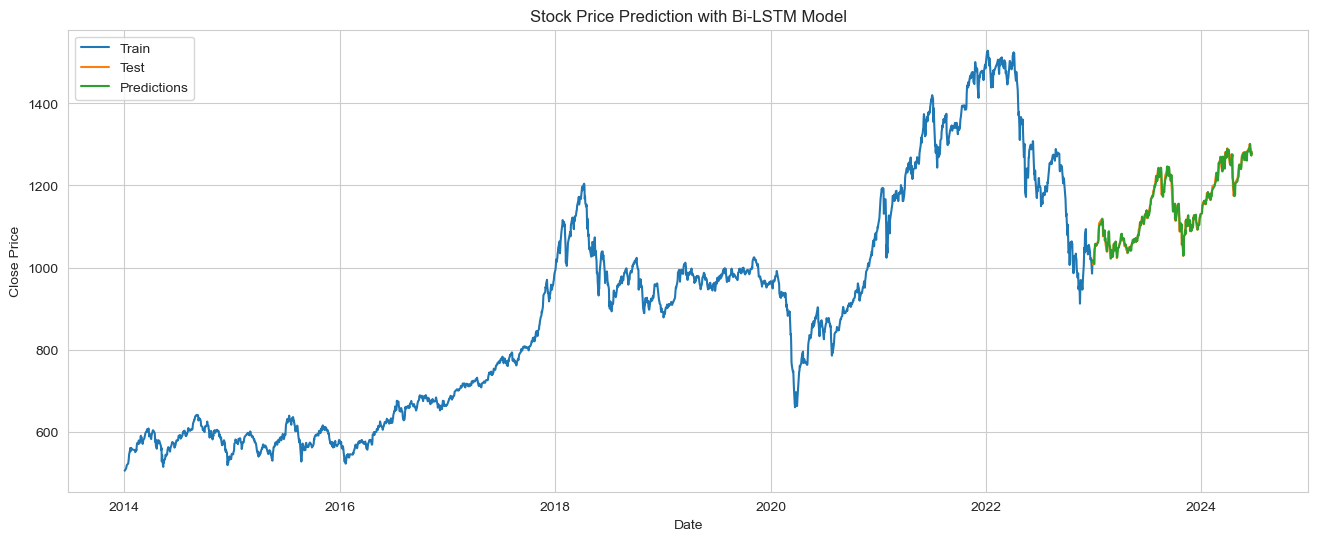

In [ ]:
# Line Chart
plt.figure(figsize=(16,6))
plt.title('Stock Price Prediction with Bi-LSTM Model')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(viz_train.index, viz_train['close'])
plt.plot(viz_test.index, viz_test[['close', 'Predictions']])
plt.legend(['Train', 'Test', 'Predictions'], loc='upper left')
plt.show()

In [ ]:
last_date = '2024-06-20'
future_dates = pd.date_range(last_date, periods=365)
ticker='VNIndex'
#Get last 365 days values and convert into array
last_180_days=VNI_subset[-365:].values

#Scale the data
last_180_days_scaled=MMS.transform(last_180_days)

# Forecast next 365 days
time_step=365
input_data = last_180_days_scaled
input_data = input_data.reshape((1, time_step, 1))

future_predictions = []
for _ in range(365):
    prediction = model.predict(input_data)
    future_predictions.append(prediction[0, 0])

    input_data = np.append(input_data[:, 1:, :], np.reshape(prediction, (1, 1, 1)), axis=1)

future_predictions = MMS.inverse_transform(np.array(future_predictions).reshape(-1, 1))


future_df = pd.DataFrame(future_predictions, index=future_dates, columns=['Predicted Value'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━

In [ ]:
future_df

,Predicted Value
2024-06-20,1284.633057
2024-06-21,1286.972168
2024-06-22,1289.295776
2024-06-23,1291.650757
2024-06-24,1294.049438
...,...
2025-06-15,1402.856323
2025-06-16,1402.842285
2025-06-17,1402.827637
2025-06-18,1402.813110


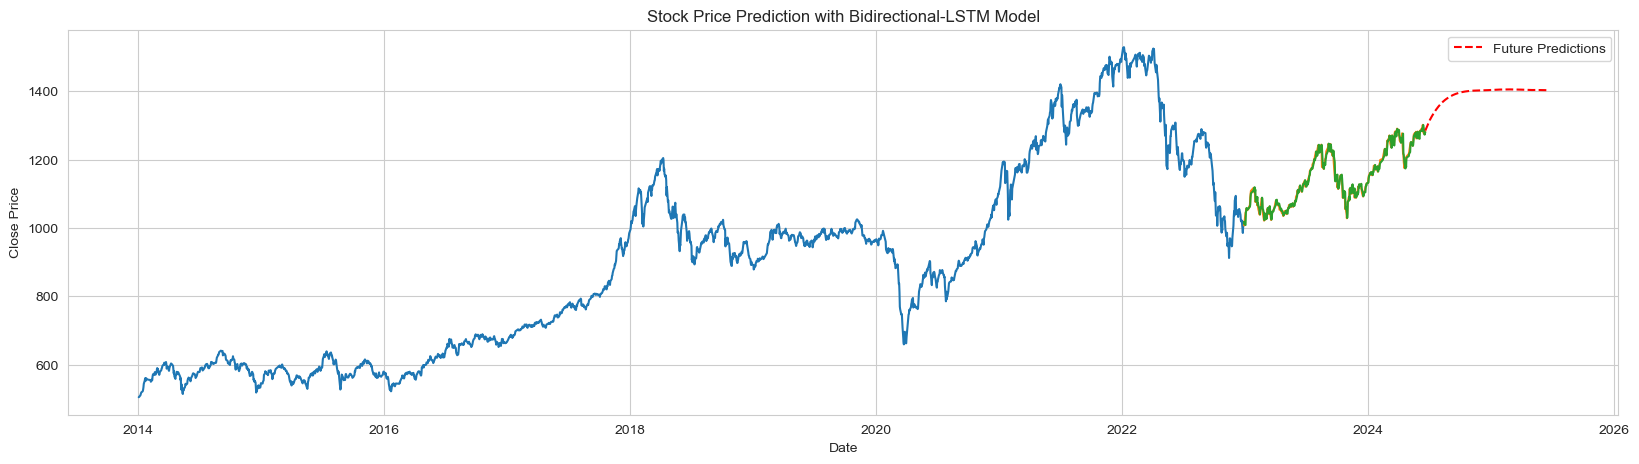

In [ ]:
# plt.plot(future_df.index, future_df.values, label='Actual Data')
plt.figure(figsize=(20,5))
plt.title('Stock Price Prediction with Bidirectional-LSTM Model')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(viz_train.index, viz_train['close'])
plt.plot(viz_test.index, viz_test[['close', 'Predictions']])
plt.plot(future_df.index, future_df.values, label='Future Predictions', color='red', linestyle='dashed')
plt.legend(['Train', 'Test', 'Predictions'], loc='upper left')
plt.legend()
plt.show()

## Predict Trend each 3 months

### Plotting how the predictions change over time

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━

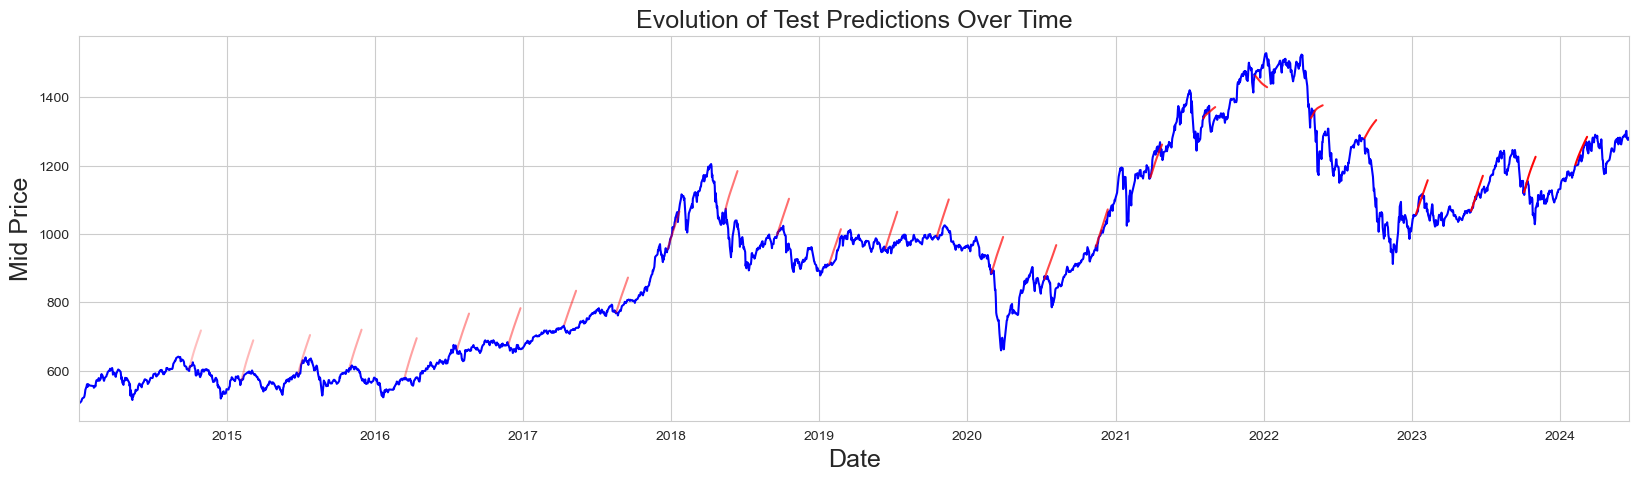

In [ ]:
# Get the entire dataset
full_data = pd.concat([viz_train['close'], viz_test['close']])
df = full_data.to_frame()

# Function to get future predictions
def get_future_predictions(data, periods):
    scaled_data = MMS.transform(data[-180:].values.reshape(-1, 1))  # Use the previous 180 days
    input_data = scaled_data.reshape((1, 180, 1))
    future_preds = []
    for _ in range(periods):
        pred = model.predict(input_data)
        future_preds.append(pred[0, 0])
        input_data = np.append(input_data[:, 1:, :], np.reshape(pred, (1, 1, 1)), axis=1)
    return MMS.inverse_transform(np.array(future_preds).reshape(-1, 1)).flatten()


predictions_over_time = []
x_axis_seq = []

# Loop through the data in 3-month intervals
for i in range(0, len(full_data), 90):
    segment = full_data.iloc[max(0, i-180):i]
    if len(segment) >= 180:
        preds = get_future_predictions(segment, 30)  # Predict the next 30 days
        predictions_over_time.append(preds)
        x_axis_seq.append(pd.date_range(segment.index[-1], periods=31)[1:].tolist())

# Convert predictions_over_time to DataFrame for consistency
predictions_df = pd.DataFrame(predictions_over_time).T
predictions_df.columns = ['Prediction_' + str(i) for i in range(len(predictions_df.columns))]
all_mid_data = df.values.flatten()

best_prediction_epoch = 15

plt.figure(figsize=(20, 5))

plt.plot(df.index, all_mid_data, color='b')

# Plotting how the predictions change over time
start_alpha = 0.25
alpha = np.linspace(start_alpha, 1, len(predictions_df.columns))
for p_i, (col, alpha_val) in enumerate(zip(predictions_df.columns, alpha)):
    if p_i < len(x_axis_seq):
        plt.plot(x_axis_seq[p_i], predictions_df[col], color='r', alpha=alpha_val)

plt.title('Evolution of Test Predictions Over Time', fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Mid Price', fontsize=18)
plt.xlim(df.index[0], df.index[-1])


plt.show()
